##ANOVA 1 vía

Ejemplo basado en este [notebook](https://www.kaggle.com/code/hamelg/python-for-data-26-anova). 

In [2]:
#Instalamos biblioteca que necesitaremos más adelante
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=b86f3d1d6dce912d3ca0547b2a094521cf0d80e61abf1d2736ecbd2430480884
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [3]:
#Cargar bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
import scipy.stats as stats

Suponemos que tenemos un grupo de votantes de distintas etnias (*races*). 
Estos votantes tienen distintas edades. 

Nota: Usando pandas se están generando datos aleatorios usando [random.choice(...)](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)

In [4]:
# Generar datos
np.random.seed(12)

races =   ["asian","black","hispanic","other","white"]

voter_race = np.random.choice(a= races,
                              p = [0.05, 0.15 ,0.25, 0.05, 0.5],
                              size=1000)

voter_age = stats.poisson.rvs(loc=18,
                              mu=30,
                              size=1000)

#Grupos etarios por etnia
voter_frame = pd.DataFrame({"race":voter_race,"age":voter_age})
groups = voter_frame.groupby("race").groups

#Dataset de cada grupo
asian = voter_age[groups["asian"]]
black = voter_age[groups["black"]]
hispanic = voter_age[groups["hispanic"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

In [5]:
voter_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   race    1000 non-null   object
 1   age     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


<Axes: xlabel='race', ylabel='age'>

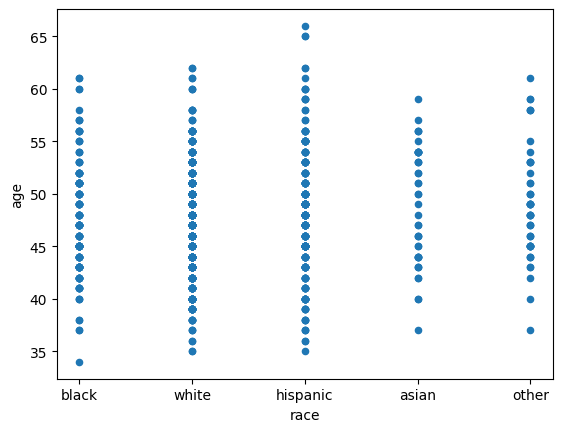

In [6]:
#scatterplot
voter_frame.plot(kind='scatter',x='race',y='age') # scatter plot

Text(0.5, 1.0, 'Distribución de edades')

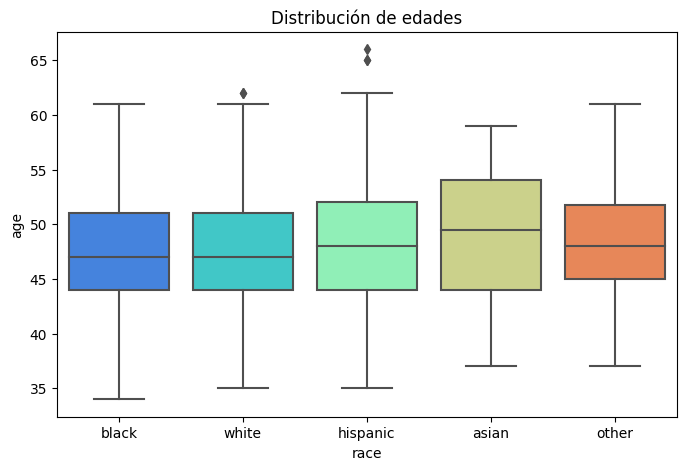

In [7]:
plt.figure(figsize=(8,5))
sns.boxplot(x='race',y='age',data=voter_frame, palette='rainbow')
plt.title("Distribución de edades")

#Hipótesis

¿Cuál es la pregunta que se podría plantear el investigador aquí?

*>> ¿Hay diferencias de edades en los votantes según su etnia?*

En otras palabras, ¿son los grupos todos iguales?

Por lo tanto, 

* H0 = las medias de todos los grupos son iguales. 
* H1 = la media de al menos uno de los grupos es distinta. 

#Supuestos

* Normalidad: pendiente de verificar
* Igualdad de varianza: pendiente de verificar
* Independencia de la muestra: lo podemos suponer
* La variable de respuesta es continua: es la edad



In [8]:
#Verificamos normalidad
pg.normality(data=voter_frame, dv='age', group = 'race')

,W,pval,normal
race,,,
black,0.983178,0.069215,True
white,0.992187,0.008423,False
hispanic,0.986496,0.021085,False
asian,0.951856,0.064519,True
other,0.962465,0.112762,True


Considerar que:
* ANOVA unidireccional es bastante robusto respecto a violaciones del supuesto de normalidad. 
* En muestras grandes, Shapiro-Wilk tiende a decir que los datos no son normales. 

En este caso, se puede recurrir a graficar los datos para hacer una verificación visual. 

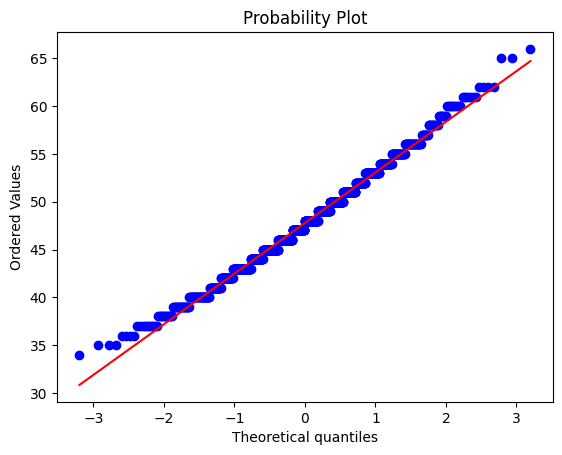

In [9]:
from scipy import stats
import matplotlib.pyplot as plt

stats.probplot(voter_age, dist="norm", plot=plt)
plt.show()

In [10]:
#Verificamos igualdad de varianzas
pg.homoscedasticity(data=voter_frame, dv='age', group='race')

,W,pval,equal_var
levene,1.738983,0.139164,True


In [11]:
#Ejecutar ANOVA - Forma 1
stats.f_oneway(asian, black, hispanic, other, white)

F_onewayResult(statistic=1.7744689357329695, pvalue=0.13173183201930463)

In [13]:
#Ejecitar ANOVA -  Forma 2
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('age ~ race', data = voter_frame).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

             sum_sq     df         F    PR(>F)
race        199.369    4.0  1.774469  0.131732
Residual  27948.102  995.0       NaN       NaN


##Interpretación de resultados

Aquí interesan dos valores:
* Estadístico F: recordar que mide si las medias de diferentes muestras son significativamente diferentes o no (entre más pequeño el valor, más similares son las medias muestrales de los grupos)
* p_value: lo usamos para aceptar o rechazar la hipótesis nula, considerando el intervalo de confianza (0.05 usualmente)

Por tanto, dados los valores de F (1.77, relativamente bajo) y p (p > 0.05), no podemos rechazar H0. Es decir, no hay diferencias significativas entre los miembros de cada grupo. 


#Cambiando el ejemplo

Ahora, modifiquemos uno de los grupos a propósito para ver los resultados. 

In [14]:
np.random.seed(12)

voter_race = np.random.choice(a= races,
                              p = [0.05, 0.15 ,0.25, 0.05, 0.5],
                              size=1000)

#Noten que se usa una distribución diferente para las edades de las personas hispanas
white_ages = stats.poisson.rvs(loc=18, 
                              mu=32,
                              size=1000)

voter_age = stats.poisson.rvs(loc=18,
                              mu=30,
                              size=1000)

voter_age = np.where(voter_race=="white", white_ages, voter_age)

voter_frame = pd.DataFrame({"race":voter_race,"age":voter_age})
groups = voter_frame.groupby("race").groups   

asian = voter_age[groups["asian"]]
black = voter_age[groups["black"]]
hispanic = voter_age[groups["hispanic"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

Text(0.5, 1.0, 'Distribución de edades')

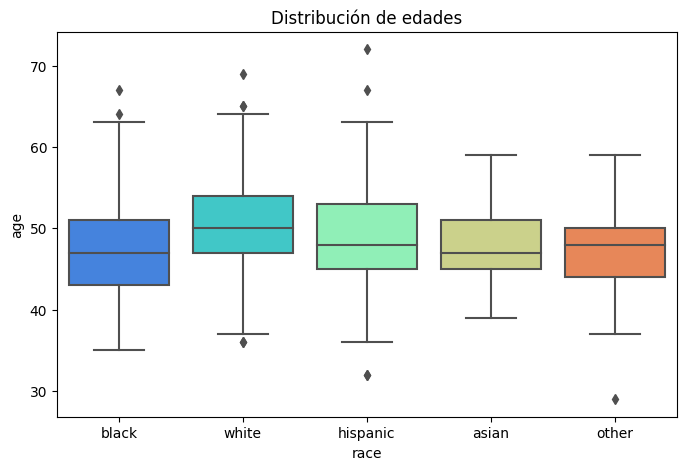

In [15]:
plt.figure(figsize=(8,5))
sns.boxplot(x='race',y='age',data=voter_frame, palette='rainbow')
plt.title("Distribución de edades")

In [16]:
pg.normality(data=voter_frame, dv='age', group = 'race')


,W,pval,normal
race,,,
black,0.970566,0.002992,False
white,0.994860,0.083491,True
hispanic,0.988187,0.042626,False
asian,0.959741,0.127270,True
other,0.973301,0.313675,True


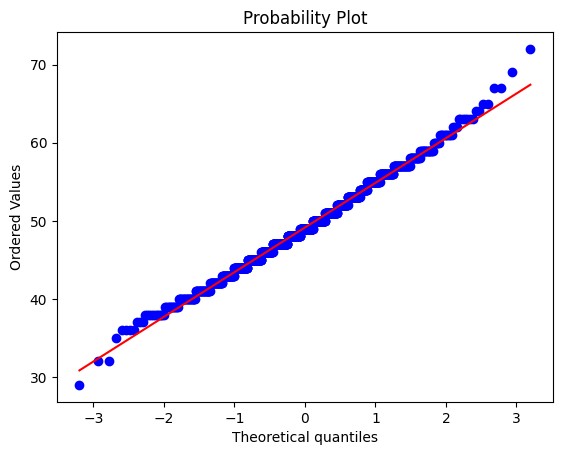

In [17]:
from scipy import stats
import matplotlib.pyplot as plt

stats.probplot(voter_age, dist="norm", plot=plt)
plt.show()

In [18]:
pg.homoscedasticity(data=voter_frame, dv='age', group='race')

,W,pval,equal_var
levene,0.947724,0.435529,True


In [19]:
#ANOVA - Forma 1
stats.f_oneway(asian, black, hispanic, other, white)

F_onewayResult(statistic=10.164699828386366, pvalue=4.5613242113994585e-08)

In [20]:
#ANOVA -  Forma 2

model = ols('age ~ race', data = voter_frame).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

                sum_sq     df        F        PR(>F)
race       1284.123213    4.0  10.1647  4.561324e-08
Residual  31424.995787  995.0      NaN           NaN


# Interpretación de resultados

¿Qué se puede decir de F y p ahora? (respecto a la hipótesis

>>El elevado valor de F indica que las medias de las diferentes muestras son significativamente diferentes
>>Con un p value mucho menor a 0.05 obtenemos mucha confianza para rechazar H0. Es decir, sí hay diferencias significativas entre los miembros de cada grupo.

#Verificar cuál es el grupo que difiere

El resultado de ANOVA nos indica sí hay diferencia en al menos una de las medias (de uno de los grupos), pero no sabemos cuál. Para verificarlo, hacemos el test de Tukey. Este hace una comparación de cada par de grupos en el dataset. 

group1,group2,meandiff,p-adj,lower,upper,reject
asian,black,-0.8032,0.9208,-3.4423,1.836,False
asian,hispanic,0.4143,0.9915,-2.1011,2.9297,False
asian,other,-1.0645,0.8906,-4.2391,2.11,False
asian,white,1.9547,0.1751,-0.4575,4.3668,False
black,hispanic,1.2175,0.2318,-0.386,2.821,False
black,other,-0.2614,0.9986,-2.7757,2.253,False
black,white,2.7579,0.0,1.3217,4.194,True
hispanic,other,-1.4789,0.4374,-3.863,0.9053,False
hispanic,white,1.5404,0.004,0.3468,2.734,True
other,white,3.0192,0.0028,0.7443,5.2941,True


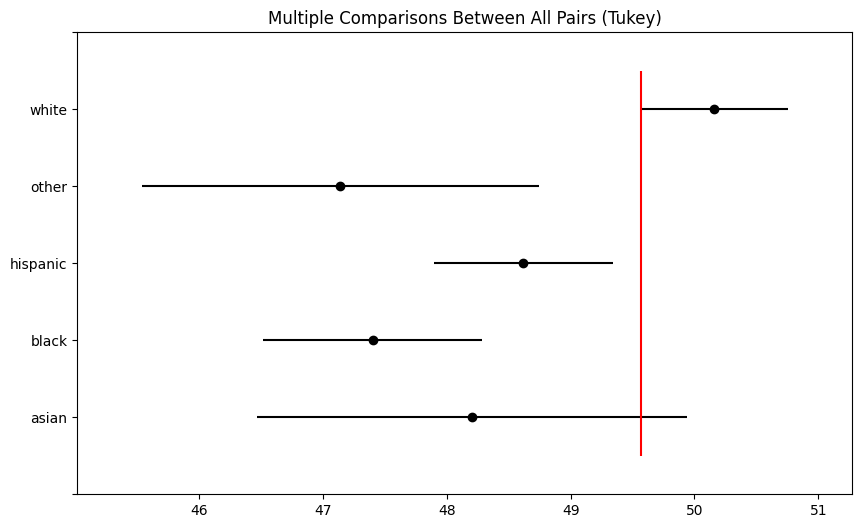

In [21]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=voter_age,     # Data
                          groups=voter_race,   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey.summary()

#Interpretación de los datos

¿Qué se puede decir del resultado del test de Tukey?

>> El test de Turkey nos muestra que hay una diferencia significativa entre la media del grupo 'white' y los demás grupos, con una ligera (casi) excepción con el grupo 'Asian' 